#

In [ ]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week2()

--2022-02-26 15:55:05--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2022-02-26 15:55:05 (32.4 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


In [ ]:
# set tf 1.x for colab
%tensorflow_version 1.x

TensorFlow 1.x selected.


# MNIST digits classification with TensorFlow
###### MNIST is a large database of handwritten digits that is commonly used for training various image processing systems.

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week2/v2/images/mnist_sample.png?raw=1" style="width:30%">

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

Using TensorFlow backend.


# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [ ]:
import keras
from matplotlib import pyplot

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # rescale value from [0-255] to [0-1]
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))
print('X_validate:  '  + str(X_val.shape))
print('Y_validate:  '  + str(y_val.shape))

X_train: (50000, 28, 28)
Y_train: (50000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
X_validate:  (10000, 28, 28)
Y_validate:  (10000,)


X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


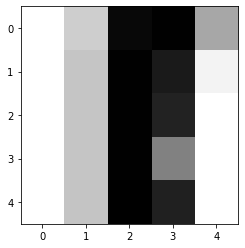

And the whole sample:


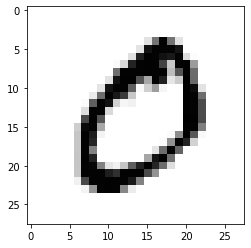

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [ ]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

Logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [ ]:
#Flatten the images (28x28 -> 784) with X_train.reshape((X_train.shape[0], -1)) to simplify our linear model implementation
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [ ]:
#Convert y_train to one-hot encoded vectors that are needed for cross-entropy
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [ ]:
s = reset_tf_session()

In [ ]:
# Model parameters: Weights and bias
## tf.get_variable(...) with shape[0] = 784
W = tf.get_variable('W', shape=(X_train_flat.shape[1],10), dtype=tf.float32, trainable=True) 
b = tf.get_variable("b", shape=(10,), dtype=tf.float32)


In [ ]:
# Placeholders for the input dat
## tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_X = tf.placeholder(shape=(None, X_train_flat.shape[1]), dtype=tf.float32)
### tf.placeholder(...) for one-hot encoded true labels
input_y = tf.placeholder(shape=(None, y_train_oh.shape[1]), dtype=tf.float32) 

In [ ]:
# Compute predictions
logits = input_X @ W + b #logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits) #apply tf.nn.softmax to logits to cal true weights
classes =tf.argmax(probas,1) ### apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=logits)) ### cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss) ### optimizer step that minimizes the loss

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS): 
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuN%2BOP7QHwm/Zx8JW/jT4veJ5dPtL7U4dN0u2stLub%2B91K9lDGO1tLO0jluLudlR2EUMbvtR2xhWI7KvFv2u/gP8VPiX4h%2BGfxl%2BBd14fl8X/CrxjPrWmaJ4tu57bTdYhudLvdMubaW4ghmktH8q9aSOdYZtrR7TGyu2ACjpH/AAUr/Y71rxm3w8tvHviCDW7fSodU1bTtR%2BHOvWkmi2EhuAt3qXn2SDTIAbWcNLdmFEKYYqWUGbwn/wAFH/2NfGfg/wAQ%2BOtM%2BLFza6f4Y0e11fVBrnhPVdMuJNPuXMdreWtvd2sU19bzyAxwy2ySpM5CRlmIB86vP2GPjP8AHW0/aRP7Qt74V8My/tB/CPTvBskfgrWLrUzo7RWusWsr%2BbcWtqZ1VNRiZDsXeyygogxuy9Y/Y2/at%2BM%2Btaz8UP2lPh38G9X1e0%2BE6eBtB8E6d4n1QaRrSy6jaXt5fXd2bBJ9PYmyg%2BzxQw3BtnDP50hIwAeyX/7fP7N2k%2BAbH4h6tdeOLSHVPED6Jpeh3Xwj8SR67e3yW5uXjh0dtPGoShYAZTIluUCKzFsA49P8JeOfDfjbwTY/EPRbi5i0rULBbyCTVNPnsZY4iu7MsFykcsDAfeSRVZSCGAIIr41tv2Gf2tJfgpJ4W8feGPCnjS%2Bh%2BIcut%2BC9B1n9ofxXb3fgOxOmxWoi0/xbHp7atcSGUXcreZDGBHeGENsjGfUvB/7Bmq%2BKfgJo3hb9pz46%2BOPEfj5PhtdeFtf8Q6T8Q9at9Muhc2tzbyTPpa3SWN5MiXTBbq4tmmdoopWKuibADc8Mf8FJP2MvF/h7xJ4s0b4tXK6Z4W8GXni6/vr7wlqtpFe6BaruuNU09p7VBqtogK5nsvPQmSMAkyIG4n40f8FdP2YfAf7M/wATf2gfhW%2Bs%2BM7v4b%2BDYfEjeGW8L6xps2r2Nw7R2t3avNYFrixlkRh9vgjmtkVWdnCqSPHfC/8AwSh%2BNC/BPxf8LPFnh3w9J4h/4UL4j8A%2BC/Hmo/tD%2BNvECSXGpWEdp5h0jVUkttGtpDDE8scEl0yeVGqFggz6P%2B1L/wAE5vih%2B0BYeKtE0Pxj4d0q2179le%2B%2BGlrLM87GDVpLiOWGdo1iANqNhBIbzBnhO9AHqkv/AAUU/ZZt/E3hrwJeav41tvEni7TpdQ0HwpefCTxLDq8tnFd/Y5LmSwk08XNvCkxG6SaNEVGWUkRsrmXwN/wUT/Y7%2BJGqarpXhD4tyXB0rQ9Q1lbufw1qVvaapp1iwS8u9NuZrdYdVhhYqHeyedVLqCfmGcXwR8APjz4x/apsf2oPjn4f8HeH5JPg5f8Ag/VNE8J%2BK7vVTBcy6tHcpJDcz6fZl4mgiUsTGjJIdoV1USHwGb9hz9pf4bfs8%2BF/Cnxo1rwIPCP7N3wP8SaB4L1PwrfXcmpeKd2hHTLe4vbeW2ii04JZozSQxS3QknZXDxqgQgH0D4U/4Kl/sL%2BNPBus/ELQ/jLdrouheDj4tutRv/BmsWcdzoIKB9Vs/PtEN/ZxmRBJPbCWOLcPMZc167a/GD4c3vxcuPgVZ%2BIxN4qtPDUGv3emRWsrCHTp55beGd5QnlL5ksE6ohfe3kyEKQjEfFX7I/7P3xC8WfBL4Q/Hb9t/Uvhlovww%2BG/7L9z4fgk07W5wmr6bqmnaWby%2B1X7VBDDpkEVppyq0CS3CZleRplWNVrsP%2BCK3wr8d6P8As76n8evit4tbxFrHjW%2Bg03w54hlgaOS%2B8I6JF/ZWiXBD8/6VDDNqhPd9WcgKCFAB9lUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4jpH/AAUY/Y91K716z1P4pXnh5vDnhy58QahJ418I6roMc2k27pHPf2smpWsC31ujyRK0tsZUBljGcuufab2K5ms5YbO6EEzxMsUxj3%2BWxHDbT1wecd6/MTV/%2BCOX7cvxf1bwvrnxu%2BOOhvrfhrwfqFnqHijUPit4m8TjxDrf2zSr611E6XfRQ2Wk20lzpi%2BfYWQCiOTassgVAoB9sv8At/8A7MNr8NG%2BLGseIPFWlaW2uQaNY2eufDLX7DVNTv5kMkMFlptxYpe37SIGdfs8MgZUdgSEYjovAf7VnwP%2BI%2Bv2XhPw54h1SHV7/wAKT%2BJIdI1rwrqWmXaabDd/ZJZZYby3ikgdZ/kMMirL32bea8m%2BJ3wc/bd%2BMTfD342654N%2BFWh/EP4UeOptY8P%2BGbXxxqV/ouuWdxpN3plzHcXz6VDNYzFL2SSN0tbgRmIKfMEjYq/En4Dftwa/8ZfDv7TXgfRvhXaeLL74Yar4L8Y6FqXivUpLDSFuL%2BG6tb%2ByuE04SagYhG6yW8sVoJS4xLFjkA7jSf8Ago3%2ByB4j17wL4W8K/EbVdZ1P4k%2BDdK8W%2BDdO0TwPrN7PeaHqL7LXUZEgtGa1t92PMknEa24ZTN5QYE7Hw1/bc/Zu%2BK/xGufhP4Z8X6tZ6/b6Xc6nDZeJ/BmraIt/Y28iRz3dlLqNrBHfwRvLEHltmkRfMQkgMpPlH7Cn7CXxY/Zh1/4caz488QeGrs%2BDv2UvCPwxv30i5nlZtW0t5muZovMgj3Wrb02MxV22/NGmBXjXw0/4JV/tjeJ/ij4X8TftTfGGz1SLT/AHivwv408TQfF/xJrV54il1exS2/tO10y%2Bhj0/QjlSxtLRSi5UCZxGq0AfUvhP/gov%2ByP410WPxVoPjvXP7DuNV0vT9P8AEt78P9btdK1GXUr2OyspLS%2Bns0tryCW5mijFxBI8IMqFnCsCfS/C3xd%2BHnjX4geKfhd4X8Q/a9c8FyWcfie0S0mC2Ml1B9ogjMrII3doSshRGZkWSMsFEibvmHxx4E%2BIvhX/AIJ7eNPgR/wUM8T/AAq8EeAtB%2BGkWgW3xM8O%2BLbsM06RpbWupPaXVnAmmzLMLeSGCO4umM5REcnaG7X/AIJX/D74seG/2RNK%2BKv7RVglv8TvixfS%2BOviJCtu0X2e/v1jMNpsb5k%2By2MdlZ7TkgWuDQB9G0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeL/H

# MLP with hidden layers

In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically, able to choose an activation function
Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [ ]:
hidden1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid)
logits = tf.layers.dense(hidden2, 10)

probas = tf.nn.softmax(logits)
classes = tf.argmax(probas,1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=input_y))

step = tf.train.AdamOptimizer().minimize(loss)



s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS): 
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuN%2BOP7QHwm/Zx8JW/jT4veJ5dPtL7U4dN0u2stLub%2B91K9lDGO1tLO0jluLudlR2EUMbvtR2xhWI7KvFv2u/gP8VPiX4h%2BGfxl%2BBd14fl8X/CrxjPrWmaJ4tu57bTdYhudLvdMubaW4ghmktH8q9aSOdYZtrR7TGyu2ACjpH/AAUr/Y71rxm3w8tvHviCDW7fSodU1bTtR%2BHOvWkmi2EhuAt3qXn2SDTIAbWcNLdmFEKYYqWUGbwn/wAFH/2NfGfg/wAQ%2BOtM%2BLFza6f4Y0e11fVBrnhPVdMuJNPuXMdreWtvd2sU19bzyAxwy2ySpM5CRlmIB86vP2GPjP8AHW0/aRP7Qt74V8My/tB/CPTvBskfgrWLrUzo7RWusWsr%2BbcWtqZ1VNRiZDsXeyygogxuy9Y/Y2/at%2BM%2Btaz8UP2lPh38G9X1e0%2BE6eBtB8E6d4n1QaRrSy6jaXt5fXd2bBJ9PYmyg%2BzxQw3BtnDP50hIwAeyX/7fP7N2k%2BAbH4h6tdeOLSHVPED6Jpeh3Xwj8SR67e3yW5uXjh0dtPGoShYAZTIluUCKzFsA49P8JeOfDfjbwTY/EPRbi5i0rULBbyCTVNPnsZY4iu7MsFykcsDAfeSRVZSCGAIIr41tv2Gf2tJfgpJ4W8feGPCnjS%2Bh%2BIcut%2BC9B1n9ofxXb3fgOxOmxWoi0/xbHp7atcSGUXcreZDGBHeGENsjGfUvB/7Bmq%2BKfgJo3hb9pz46%2BOPEfj5PhtdeFtf8Q6T8Q9at9Muhc2tzbyTPpa3SWN5MiXTBbq4tmmdoopWKuibADc8Mf8FJP2MvF/h7xJ4s0b4tXK6Z4W8GXni6/vr7wlqtpFe6BaruuNU09p7VBqtogK5nsvPQmSMAkyIG4n40f8FdP2YfAf7M/wATf2gfhW%2Bs%2BM7v4b%2BDYfEjeGW8L6xps2r2Nw7R2t3avNYFrixlkRh9vgjmtkVWdnCqSPHfC/8AwSh%2BNC/BPxf8LPFnh3w9J4h/4UL4j8A%2BC/Hmo/tD%2BNvECSXGpWEdp5h0jVUkttGtpDDE8scEl0yeVGqFggz6P%2B1L/wAE5vih%2B0BYeKtE0Pxj4d0q2179le%2B%2BGlrLM87GDVpLiOWGdo1iANqNhBIbzBnhO9AHqkv/AAUU/ZZt/E3hrwJeav41tvEni7TpdQ0HwpefCTxLDq8tnFd/Y5LmSwk08XNvCkxG6SaNEVGWUkRsrmXwN/wUT/Y7%2BJGqarpXhD4tyXB0rQ9Q1lbufw1qVvaapp1iwS8u9NuZrdYdVhhYqHeyedVLqCfmGcXwR8APjz4x/apsf2oPjn4f8HeH5JPg5f8Ag/VNE8J%2BK7vVTBcy6tHcpJDcz6fZl4mgiUsTGjJIdoV1USHwGb9hz9pf4bfs8%2BF/Cnxo1rwIPCP7N3wP8SaB4L1PwrfXcmpeKd2hHTLe4vbeW2ii04JZozSQxS3QknZXDxqgQgH0D4U/4Kl/sL%2BNPBus/ELQ/jLdrouheDj4tutRv/BmsWcdzoIKB9Vs/PtEN/ZxmRBJPbCWOLcPMZc167a/GD4c3vxcuPgVZ%2BIxN4qtPDUGv3emRWsrCHTp55beGd5QnlL5ksE6ohfe3kyEKQjEfFX7I/7P3xC8WfBL4Q/Hb9t/Uvhlovww%2BG/7L9z4fgk07W5wmr6bqmnaWby%2B1X7VBDDpkEVppyq0CS3CZleRplWNVrsP%2BCK3wr8d6P8As76n8evit4tbxFrHjW%2Bg03w54hlgaOS%2B8I6JF/ZWiXBD8/6VDDNqhPd9WcgKCFAB9lUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4jpH/AAUY/Y91K716z1P4pXnh5vDnhy58QahJ418I6roMc2k27pHPf2smpWsC31ujyRK0tsZUBljGcuufab2K5ms5YbO6EEzxMsUxj3%2BWxHDbT1wecd6/MTV/%2BCOX7cvxf1bwvrnxu%2BOOhvrfhrwfqFnqHijUPit4m8TjxDrf2zSr611E6XfRQ2Wk20lzpi%2BfYWQCiOTassgVAoB9sv8At/8A7MNr8NG%2BLGseIPFWlaW2uQaNY2eufDLX7DVNTv5kMkMFlptxYpe37SIGdfs8MgZUdgSEYjovAf7VnwP%2BI%2Bv2XhPw54h1SHV7/wAKT%2BJIdI1rwrqWmXaabDd/ZJZZYby3ikgdZ/kMMirL32bea8m%2BJ3wc/bd%2BMTfD342654N%2BFWh/EP4UeOptY8P%2BGbXxxqV/ouuWdxpN3plzHcXz6VDNYzFL2SSN0tbgRmIKfMEjYq/En4Dftwa/8ZfDv7TXgfRvhXaeLL74Yar4L8Y6FqXivUpLDSFuL%2BG6tb%2ByuE04SagYhG6yW8sVoJS4xLFjkA7jSf8Ago3%2ByB4j17wL4W8K/EbVdZ1P4k%2BDdK8W%2BDdO0TwPrN7PeaHqL7LXUZEgtGa1t92PMknEa24ZTN5QYE7Hw1/bc/Zu%2BK/xGufhP4Z8X6tZ6/b6Xc6nDZeJ/BmraIt/Y28iRz3dlLqNrBHfwRvLEHltmkRfMQkgMpPlH7Cn7CXxY/Zh1/4caz488QeGrs%2BDv2UvCPwxv30i5nlZtW0t5muZovMgj3Wrb02MxV22/NGmBXjXw0/4JV/tjeJ/ij4X8TftTfGGz1SLT/AHivwv408TQfF/xJrV54il1exS2/tO10y%2Bhj0/QjlSxtLRSi5UCZxGq0AfUvhP/gov%2ByP410WPxVoPjvXP7DuNV0vT9P8AEt78P9btdK1GXUr2OyspLS%2Bns0tryCW5mijFxBI8IMqFnCsCfS/C3xd%2BHnjX4geKfhd4X8Q/a9c8FyWcfie0S0mC2Ml1B9ogjMrII3doSshRGZkWSMsFEibvmHxx4E%2BIvhX/AIJ7eNPgR/wUM8T/AAq8EeAtB%2BGkWgW3xM8O%2BLbsM06RpbWupPaXVnAmmzLMLeSGCO4umM5REcnaG7X/AIJX/D74seG/2RNK%2BKv7RVglv8TvixfS%2BOviJCtu0X2e/v1jMNpsb5k%2By2MdlZ7TkgWuDQB9G0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBgfFL4m%2BE